# Classify and localize Thoracic diseases using DL!
Highlights:
1. Transfer learning using Resnet50

Plan
1. Load Data
    - Img and CSV data loaders
    - Data split
    - 
2. Preprocess 
    - Possibly augmentation
3. Run model
4. Display results
5. Localization enhancements

In [1]:
import torch
from PIL import Image
import cv2
import time
import numpy as np
import torchvision.models as models
from torch.optim import lr_scheduler
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms,utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
import os
import pandas as pd
import glob
from skimage import io
import matplotlib.pyplot as plt
import os 

%matplotlib inline
use_gpu = torch.cuda.is_available()


In [2]:
# Config
DATA_DIR = 'data'
TRAIN_DIR = 'train'
TEST_DIR = 'test'
VAL_DIR = 'val'
TRAIN_DS_LOC = os.path.join(DATA_DIR, TRAIN_DIR)
TEST_DS_LOC = os.path.join(DATA_DIR, TEST_DIR)
VAL_DS_LOC = os.path.join(DATA_DIR, VAL_DIR)
IMG_PATTERN = '*.png'
IMG_PROPERTIES_FILE = 'Data_Entry_2017.csv'
LABEL_SEP = '|'
Height=512
Width=512



In [3]:
# Retrieve and process labels
l2i = {'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'No Finding': 10,
 'Nodule': 11,
 'Pleural_Thickening': 12,
 'Pneumonia': 13,
 'Pneumothorax': 14}

properties = pd.read_csv(IMG_PROPERTIES_FILE, skiprows=1, header=None, low_memory=False, na_filter=False).values
labels = {prop[0] : [ l2i[label] for label in  prop[1].split(LABEL_SEP)] for prop in properties}

num_classes=len(l2i)


In [4]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),

    ]),
}


In [5]:
def label_standard_array(labels):
    standard_class=np.zeros(shape=num_classes)
    for i in labels:
       standard_class[i]=1
    return standard_class
    

torch.Size([3, 256, 256])


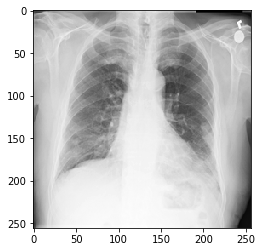

In [6]:
#def split TODO:training and test validations
class XrayFolderDS(Dataset):
    def __init__(self, root, transform = None):
        self.data = glob.glob(os.path.join(root, IMG_PATTERN))
        self.transform = transform
        # transforms.ToPILImage(),
        self.to_tensor = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        entry = self.data[index]
        name = os.path.split(entry)[-1]
        img = cv2.imread(entry)
        # img = Image.open(entry)
        img = self.transform(img)
        labels_name=label_standard_array(labels[name])
        return img,labels_name
        
test_d = XrayFolderDS(TRAIN_DS_LOC,data_transforms['train'])[0][0]
# convert to np and remove extra dim
numpy_d = test_d.numpy()[0] 
print(test_d.size())
plt.imshow(numpy_d, cmap='gray') # Remove gray for green normalized image :D
plt.show()

In [9]:
#Test the loading code
class XrayFolderDS2(Dataset):
    def __init__(self, root, transform = None):
        self.data = glob.glob(os.path.join(root, IMG_PATTERN))
        self.transform = transform
        # transforms.ToPILImage(),
        self.to_tensor = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        entry = self.data[index]
        name = os.path.split(entry)[-1]
        img = cv2.imread(entry)
        # img = Image.open(entry)
        img = self.transform(img)
        labels_name=label_standard_array(labels[name])
        #labels_name = labels[name]
        return img,labels_name
    
import line_profiler

def ftst():
    
    ds = DataLoader(tds, batch_size=25, shuffle=True)
    s = 0
    t = time.time()
    for e, i in enumerate(ds):
        s+=len(i)
        if e == 1000:
            print(i[0].size())
            break
    print('took {:.4f} seconds '.format(time.time() - t,))

tds = XrayFolderDS2(TRAIN_DS_LOC,data_transforms['train'])

lpx = line_profiler.LineProfiler(tds.__getitem__)
#print(dir(lpx))
lpx(ftst)()
lpx.print_stats()
    

True
torch.Size([25, 3, 256, 256])
took 8.8826 seconds 
Timer unit: 4.09837e-07 s

Total time: 7.78859 s
File: <ipython-input-9-5b7477a6a28b>
Function: __getitem__ at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                               def __getitem__(self, index):
    13      2525         8608      3.4      0.0          entry = self.data[index]
    14      2525       151246     59.9      0.8          name = os.path.split(entry)[-1]
    15      2525     10948026   4335.9     57.6          img = cv2.imread(entry)
    16                                                   # img = Image.open(entry)
    17      2525      7801637   3089.8     41.1          img = self.transform(img)
    18      2525        90000     35.6      0.5          labels_name=label_standard_array(labels[name])
    19                                                   #labels_name = labels[name]
    20      2525         4593      1.8      0.0          return img,lab

In [7]:
# Hyperparameters
BATCH_SIZE = 25


In [8]:
# Prepare Data
# print( [d for d in os.listdir(TRAIN_DS_LOC) ] )

#print(os.getcwd()+'\\data\\train\\', torchvision.datasets.folder.find_classes('data/train'))
train_dataset = XrayFolderDS(TRAIN_DS_LOC,data_transforms['train'])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = XrayFolderDS(VAL_DS_LOC,data_transforms['val'])
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

dataloaders={'train':train_dataloader,'val':val_dataloader}
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}

# test_dataset = XrayFolderDS(TRAIN_DS_LOC,data_transforms['test'])
# test_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# TODO: Implement k fold cross validation


In [9]:
# def show_xray_batch(sample_batched):
#     """Show image with landmarks for a batch of samples."""
#     xrays_batch,labels_batch = sample_batched
#     print('labels_batch batch size',labels_batch.shape)
#     print(len(labels_batch))
#     grid_1 = utils.make_grid(xrays_batch)
#     plt.imshow(grid_1.numpy().transpose(( 1,2, 0)))


# for i_batch, sample_batched in enumerate(train_dataloader):
#     print ('Batch Number', i_batch)
#     # observe 4th batch and stop.
#     if i_batch == 5:
#         plt.figure()
#         show_xray_batch(sample_batched)
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

In [10]:
xray_model = models.resnet50(pretrained=True)


In [11]:
num_ftrs = xray_model.fc.in_features
# changing the final_layer for our images 
xray_model.fc = nn.Linear(num_ftrs,num_classes)
print(xray_model.fc)
print(xray_model)

Linear (2048 -> 15)
ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )

)


In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    i = 0 
    start_time = time.time()


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            print('Total Batches: ', len(dataloaders[phase]))

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                
                if phase == 'train':
                    inputs, labels = Variable(inputs), Variable(labels)
                else:
                    inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
                
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
               

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = torch.sigmoid(model(inputs))
                preds = torch.sign(torch.sign(outputs.data-0.5)+1)
                # print(outputs.size())
                # print(labels)
                loss = criterion(outputs.double(), labels)
                
                if i%100==0:
                    print("i is",i)
                    print("time passed. {:.2f} ".format(time.time()-start_time))
                    print(' Loss: {:.4f} '.format(loss.data[0]))
                    
        
                i=i+1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                part_corr = torch.sum((preds == labels.data.float()),1).double()
                # Average fraction of correct labels
                corr_avg =  torch.mean(part_corr)/float(num_classes)
                #corrects = torch.sum(part_corr == num_classes)
                running_corrects += torch.sum(part_corr)
                
                if i%100==0:
                    print('Batch Accuracy ', corr_avg)

            epoch_loss = running_loss / float(dataset_sizes[phase])
            epoch_acc = running_corrects / (float(dataset_sizes[phase]) * float(num_classes))


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc ))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            
            if phase == 'train':
                torch.save(model.state_dict(), open("projectx_%s_%f.model" % (epoch, epoch_loss), 'wb'))



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Optimizer and Loss

In [13]:
if use_gpu:
    xray_model = xray_model.cuda()
    print("GPU POWER FTW")

criterion = nn.MultiLabelSoftMarginLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(xray_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


GPU POWER FTW


In [14]:
model_ft = train_model(xray_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)


Epoch 0/4
----------
Total Batches:  3122
i is 0
time passed. 1.26 
 Loss: 0.9367 
Batch Accuracy  0.904
i is 100
time passed. 63.01 
 Loss: 0.6855 
Batch Accuracy  0.9253333333333333
i is 200
time passed. 126.16 
 Loss: 0.6928 
Batch Accuracy  0.9359999999999999
i is 300
time passed. 191.79 
 Loss: 0.6881 
Batch Accuracy  0.9333333333333333
i is 400
time passed. 255.63 
 Loss: 0.6916 
Batch Accuracy  0.9306666666666668
i is 500
time passed. 320.27 
 Loss: 0.6861 
Batch Accuracy  0.928
i is 600
time passed. 384.71 
 Loss: 0.6912 
Batch Accuracy  0.9253333333333333
i is 700
time passed. 453.59 
 Loss: 0.6905 
Batch Accuracy  0.9546666666666667
i is 800
time passed. 526.64 
 Loss: 0.6847 
Batch Accuracy  0.92
i is 900
time passed. 596.99 
 Loss: 0.6915 
Batch Accuracy  0.928
i is 1000
time passed. 667.56 
 Loss: 0.6867 
Batch Accuracy  0.9146666666666667
i is 1100
time passed. 736.93 
 Loss: 0.6908 
Batch Accuracy  0.912
i is 1200
time passed. 806.40 
 Loss: 0.6959 
Batch Accuracy  0.933

KeyboardInterrupt: 